In [1]:
#これはボツ

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

In [4]:
#自作モジュール
import my_cv

In [221]:
img_ori = cv2.imread('work2.png')#画像読み込み

In [222]:
#紙の部分を切り出す
img_paper = my_cv.cutting_paper(img_ori)
my_cv.display_color(img_paper)

error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-7r9u7hyj/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [179]:
class　Paper():
    def __init__(self):
        self.squares = list()
    
    
    #重複してなければ追加する
    def add(self,square):
        for sq in self.squares:
            if sq.is_same(square):
                return 0
        self.squares.append(square)
    
    def count(self):
        return len(self.squares)
    
    #ndarrayを返す
    def arr_ori(self):
        return np.stack([sq.points_ori for sq in self.squares])
    
    #label付けを行う
    def set_label(self):
        for sq in self.squares:
            if 1300<sq.get_lu_point()[0]<1400:
                sq.set_label("example_1")
            elif 1000<sq.get_lu_point()[0]<1100:
                sq.set_label("example_2")
            elif 100<sq.get_lu_point()[0]<150:
                if sq.get_lu_point()[1]< 650:
                    sq.set_label("guide_1")
                else:
                    sq.set_label("draw_1")
            elif 400<sq.get_lu_point()[0]<500:
                if sq.get_lu_point()[1]<650:
                    sq.set_label("guide_1")
                else:
                    sq.set_label("draw_1")
            else:
                print("error")
    
    def get_draws(self):
        return [sq for sq in self.squares if "draw" in sq.get_label()]
            
        
class Square():
    def __init__(self, points_ori):# np.shape(points) = (4,1,2)
        self._arrange_points(points_ori)#座標を整理
        
    #points_oriを時計周りに修正する (0,0)(1,0)(1,1)(0,1)
    def _arrange_points(self,points):
        stack = list()
        m_s_idx = np.argsort([ p[0][0] + p[0][1] for p in points])#足し算でソートしたindex
        stack.append(points[m_s_idx[0]])
        if points[m_s_idx[1]][0][0] > points[m_s_idx[2]][0][0]:
            stack.append(points[m_s_idx[1]])
            stack.append(points[m_s_idx[3]])
            stack.append(points[m_s_idx[2]])
        else:
            stack.append(points[m_s_idx[2]])
            stack.append(points[m_s_idx[3]])
            stack.append(points[m_s_idx[1]])
        self.points_ori = np.stack(stack)

    
    #左上の座標が同じかどうか
    def is_same(self, other):
        op = other.points_ori[0][0]
        mp = self.points_ori[0][0]
        if abs(op[0] - mp[0]) + abs(op[1]-mp[1]) <=30:
            return True
        return False    
                               
        
    #四角に整形して結果を保持する
    def fit_image(self,img,x=255,y=255):
        epsilon = 0.1*cv2.arcLength(self.points_ori,True)
        paper_corners= cv2.approxPolyDP(self.points_ori,epsilon,True)#紙の頂点座標
        fix_con = np.array([[[0,0]],[[x,0]],[[x,y]],[[0,y]]], dtype="int32")#整形後のサイズ
        trans_arr = cv2.getPerspectiveTransform(np.float32(paper_corners),np.float32(fix_con))#変換行列の生成
        self.img_trans = cv2.warpPerspective(img,trans_arr,(x,y))#変換
    
    def arr(self):
        return self.img_trans
    
    #左上のアドレスを(2)で返す
    def get_lu_point(self):
        return self.points_ori[0][0]
    
    def set_label(self,label):
        self.label = label
    
    def get_label(self):
        return self.label
    
    def display(self):
        cv2.imwrite("temp.png", self.img_trans)
        plt.imshow(plt.imread("temp.png"))
        plt.axis('off')
        plt.show()
    
    #img_transにたいしてfilterをかけることで文字部分のみを切り出してimg_filterとして格納する
    def filter_image(self):
        img = self.img_trans
        result = np.copy(img)
        # HSV色空間に変換
        #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # 青色のHSVの値域1
        mi = np.array([60, 60, 30])#小さくするときつくなる
        ma = np.array([255,255,255])

        # 青色領域のマスク（255：赤色、0：赤色以外）    
        mask = cv2.inRange(img, mi, ma)
        mask = cv2.bitwise_not(mask)
        for i in range(255):
            for j in range(255):
                if mask[i][j] == 0:#黒なら
                    for k in range(3):
                        result[i][j][k] = 255      
        result = cv2.fastNlMeansDenoisingColored(result,None,50,9,7,21)
        img_gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
        ret, img_thresh = cv2.threshold(img_gray, 230, 255, cv2.THRESH_BINARY)#100以上の画素255
        #my_cv.display_gray(img_thresh)
        contours, _ = cv2.findContours(img_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        img_del_min = np.copy(img_thresh)
        img_draw_con = np.copy(img_thresh)
        for con in contours:
            area = cv2.contourArea(con)
            if area<120 :
                img_del_min = cv2.drawContours(img_del_min, [con], 0, 255, -1)
        #my_cv.display_gray(img_del_min)
        self.img_filter = img_del_min
        
def angle(pt1, pt2, pt0) -> float:
    dx1 = float(pt1[0,0] - pt0[0,0])
    dy1 = float(pt1[0,1] - pt0[0,1])
    dx2 = float(pt2[0,0] - pt0[0,0])
    dy2 = float(pt2[0,1] - pt0[0,1])
    v = math.sqrt((dx1*dx1 + dy1*dy1)*(dx2*dx2 + dy2*dy2) )
    return (dx1*dx2 + dy1*dy2)/ v

# 画像上で検出された一連の正方形を返します。
def findSquares(image, lower_thre=66000, upper_thre = 71000,sq_num = 16):
    gray0 = np.zeros(image.shape[:2], dtype=np.uint8)
    # down-scale and upscale the image to filter out the noise
    rows, cols, _channels = map(int, image.shape)
    pyr = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
    timg = cv2.pyrUp(pyr, dstsize=(cols, rows))
    # 画像のBGRの色平面で正方形を見つける ( 0で固定した)
    cv2.mixChannels([timg], [gray0], (0, 0))
    # いくつかのしきい値レベルを試す
    for l in range(0, 5):
        print("==== new l ======")
        sqs = ImageSquares()
        if l == 0:
            # Cannyを適用
            # スライダーから上限しきい値を取得し、下限を0に設定します
            # （これによりエッジが強制的にマージ）
            #
            gray = cv2.Canny(gray0,50, 5)

            #Canny出力を拡張して、エッジセグメント間の潜在的な穴を削除します
            gray = cv2.dilate(gray, None)
        else:
            # apply threshold if l!=0:
            gray[gray0 >= (l+1)*255/5] = 0
            gray[gray0 < (l+1)*255/5] = 255

        # 輪郭をリストで取得
        contours, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for i, cnt in enumerate(contours):
            # 輪郭の周囲を取得
            arclen = cv2.arcLength(cnt, True)
            # 輪郭の近似
            approx = cv2.approxPolyDP(cnt, arclen*0.02, True)
            # 面積
            area = abs(cv2.contourArea(approx))
            #長方形の輪郭は、近似後に4つの角をもつ、
            #比較的広い領域
            #（ノイズの多い輪郭をフィルターで除去するため）
            #凸性(isContourConvex)になります。
            if approx.shape[0] == 4 and upper_thre > area > lower_thre and cv2.isContourConvex(approx) :
                maxCosine = 0
                #print(approx)
                for j in range(2, 5):
                    # ジョイントエッジ間の角度の最大コサインを見つけます
                    cosine = abs(angle(approx[j%4], approx[j-2], approx[j-1]))
                    maxCosine = max(maxCosine, cosine)
                # すべての角度の余弦定理が小さい場合（すべての角度が約90度）、
                # 結果のシーケンスにquandrange頂点を書き込みます
                if maxCosine < 0.1 :
                    sq = Square(approx)
                    sqs.add(sq)
        if sq_num == sqs.count():
            return sqs


In [180]:
#領域クラス
class ContourArea():
    pass

==== new l ======


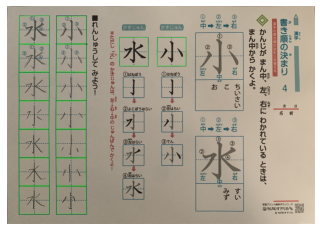

In [181]:
# 四角の角を見つける
sqs = findSquares(img_paper)
sqs.set_label()
temp = np.copy(img_paper)
# 検出した四角を描画
retimg = cv2.polylines(temp,sqs.arr_ori() , True, (0,255,0), thickness=2, lineType=cv2.LINE_8)
my_cv.display_color(temp)
#各ますに元画像を貼り付ける
for sq in sqs.squares :
    sq.fit_image(img_paper)
#sqにラベル付を行う
for sq in sqs.squares :
    sq.fit_image(img_paper)
#フィルター処理でノイズ除去する
for sq in sqs.get_draws():
    sq.filter_image()

546
1.463860933211345
(9, 1, 2)
436
1.834862385321101
(9, 1, 2)
1518
0.5270092226613966
(64, 1, 2)
64503
0.012402427775237002
(9, 1, 2)


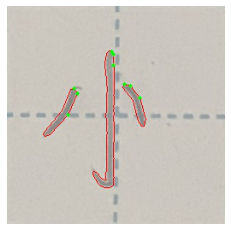

717
1.1157601115760112
(15, 1, 2)
268
2.985074626865672
(4, 1, 2)
2545
0.3142801021410332
(210, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


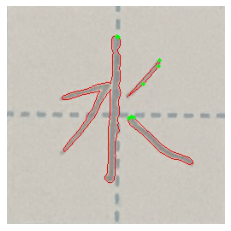

418
1.911589008363202
(6, 1, 2)
553
1.4466546112115732
(10, 1, 2)
1479
0.5409060175794456
(50, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


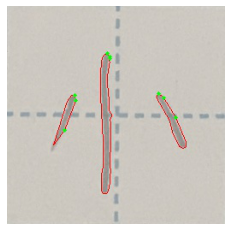

3910
0.20457741976729318
(340, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


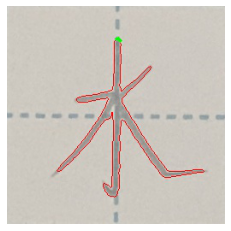

318
2.5157232704402515
(6, 1, 2)
158
5.047318611987381
(2, 1, 2)
1537
0.5203252032520326
(71, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


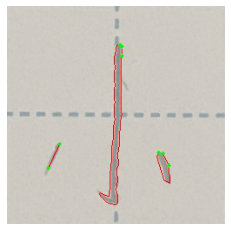

120
6.639004149377594
(2, 1, 2)
608
1.314708299096138
(20, 1, 2)
3020
0.26485681178612813
(241, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


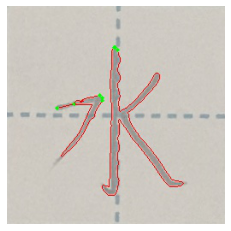

345
2.318840579710145
(6, 1, 2)
701
1.1404133998574484
(15, 1, 2)
228
3.50109409190372
(3, 1, 2)
1637
0.48869883934025654
(69, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


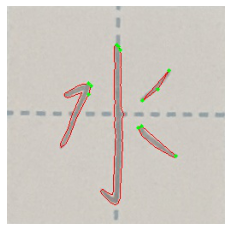

322
2.4806201550387597
(5, 1, 2)
468
1.7075773745997866
(10, 1, 2)
1593
0.5021971123666039
(76, 1, 2)
64516
0.0124000248000496
(4, 1, 2)


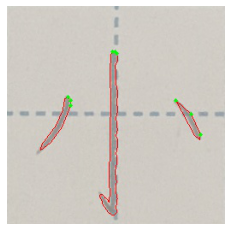

In [217]:
#コーナー検出でいい感じにやりたい
def corner_harris(sq):
    dst = cv2.cornerHarris(sq.img_filter,2,9,0.01)
    dst = cv2.dilate(dst,None)
    img = np.copy(sq.img_trans)
    img[dst>0.01*dst.max()] = [0,0,255]
    rate_parms = [0.02, 0.05, 0.06, 0.07, 0.1]
    my_cv.display_gray(img)

    
#arclenが小さすぎるとepが大きすぎる
#
# 輪郭の近似
def  poly(sq):
    thre_img = np.copy(sq.img_filter)
    contours, _ = cv2.findContours(thre_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rate_parms = [800]
    for n, rate in enumerate(rate_parms):
        resimg = sq.img_trans.copy() // 2 + 128
        for i, cnt in enumerate(contours):
            # 輪郭の周囲に比例する精度で輪郭を近似する
            size = cv2.contourArea(cnt)
            approx = cv2.approxPolyDP(cnt, rate/size, True)#第２引数が小さければ細かい近似大きければ大雑把な近似
            print(int(size))
            print(rate/size)
            print(np.shape(approx))
            if size>(255*255-5000):
                continue
            cv2.polylines(resimg, [approx.reshape(-1,2)], True, 
                        (0,0,255), thickness=1, lineType=cv2.LINE_8)
            for app in approx[0:3]:
                cv2.circle(resimg, (app[0][0],app[0][1]), 2, (0, 255, 0), thickness=-1)
        my_cv.display_color(resimg)

def convexHull(sq):
    thresh = np.copy(sq.img_filter)
    img = np.copy(sq.img_trans)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= (255*255-5000):
            hull = cv2.convexHull(cnt)
            cv2.polylines(img, [hull.reshape(-1,2)], True, 
                            (0,0,255), thickness=2, lineType=cv2.LINE_8)
            #img = cv2.circle(img, [hull], 0, (0,255,0), 1)
            print(np.shape(hull))
            for hu in hull:
                cv2.circle(img, (hu[0][0],hu[0][1]), 2, (0, 255, 0), thickness=-1)
    my_cv.display_color(img)
    

    
    
    
for sq in sqs.get_draws():
    poly(sq)

  

In [220]:

class Paper():
    def __init__(self,paper_img,char1,char2):#紙の領域が切り取られたimgを受け取る
        self.chars = find_chars(img)#文字の集合16個で固定
        
        self.drawchars1 = list() # 採点する文字１の配列
        self.drawchars2 = list() # 採点する文字２の配列
        self.char1_mihon = None # 文字１の見本
        self.char2_mihon = None # 文字２の見本
        self.labeling()#ラベリングして上に振り分ける

    
    def count(self):
        return len(self.squares)
    
    #ndarrayを返す
    def arr_ori(self):
        return np.stack([sq.points_ori for sq in self.squares])
    
    #label付けを行う
    def labeling(self,ch):
        for sq in self.chars:
            if 1300<sq.get_lu_point()[0]<1400:
                sq.set_label("example_1")
            elif 1000<sq.get_lu_point()[0]<1100:
                sq.set_label("example_2")
            elif 100<sq.get_lu_point()[0]<150:
                if sq.get_lu_point()[1]< 650:
                    sq.set_label("guide_1")
                else:
                    sq.set_label("draw_1")
            elif 400<sq.get_lu_point()[0]<500:
                if sq.get_lu_point()[1]<650:
                    sq.set_label("guide_1")
                else:
                    sq.set_label("draw_1")
            else:
                print("error")
                
        
    def find_chars(self,img, lower_thre=66000, upper_thre = 71000,sq_num = 16):#img
        gray0 = np.zeros(img.shape[:2], dtype=np.uint8)
        rows, cols, _channels = map(int, img.shape)        # down-scale and upscale the image to filter out the noise
        pyr = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
        timg = cv2.pyrUp(pyr, dstsize=(cols, rows))
        cv2.mixChannels([timg], [gray0], (0, 0))# 画像のBGRの色平面で正方形を見つける ( 0で固定した)
        for l in range(0, 5):# いくつかのしきい値レベルを試す
            if l == 0:
                # Cannyを適用
                # スライダーから上限しきい値を取得し、下限を0に設定します
                # （これによりエッジが強制的にマージ）
                gray = cv2.Canny(gray0,50, 5)
                #Canny出力を拡張して、エッジセグメント間の潜在的な穴を削除します
                gray = cv2.dilate(gray, None)
            else:
                # apply threshold if l!=0:
                gray[gray0 >= (l+1)*255/5] = 0
                gray[gray0 < (l+1)*255/5] = 255
            contours, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            chars = list()
            for i, cnt in enumerate(contours):
                arclen = cv2.arcLength(cnt, True)# 輪郭の周囲を取得
                approx = cv2.approxPolyDP(cnt, arclen*0.02, True)# 輪郭の近似
                area = abs(cv2.contourArea(approx))# 面積
                #長方形の輪郭は、近似後に4つの角をもつ、
                #比較的広い領域
                #（ノイズの多い輪郭をフィルターで除去するため）
                #凸性(isContourConvex)になります。
                if approx.shape[0] == 4 and upper_thre > area > lower_thre and cv2.isContourConvex(approx) :
                    maxCosine = 0
                    #print(approx)
                    for j in range(2, 5):   # ジョイントエッジ間の角度の最大コサインを見つけます
                        cosine = abs(angle(approx[j%4], approx[j-2], approx[j-1]))
                        maxCosine = max(maxCosine, cosine)
                    if maxCosine < 0.1 :# すべての角度の余弦定理が小さい場合（すべての角度が約90度）、
                        char = Char(approx)
                        for ch in self.chars:
                            if ch.is_same(char):
                                break
                            self.chars.append(char)
            if sq_num == len(chars):
                return chars

class Char():
     def __init__(self, points_ori,img_paper):# np.shape(points) = (4,1,2)
        self.points_ori = self._arrange_points(points_ori)# paperにおける自身の座標
        self.img_sq = self._fit_image(self,img_paper)# fit_imag
    #points_oriを時計周りに修正する (0,0)(1,0)(1,1)(0,1)
    def _arrange_points(self,points):
        stack = list()
        m_s_idx = np.argsort([ p[0][0] + p[0][1] for p in points])#足し算でソートしたindex
        stack.append(points[m_s_idx[0]])
        if points[m_s_idx[1]][0][0] > points[m_s_idx[2]][0][0]:
            stack.append(points[m_s_idx[1]])
            stack.append(points[m_s_idx[3]])
            stack.append(points[m_s_idx[2]])
        else:
            stack.append(points[m_s_idx[2]])
            stack.append(points[m_s_idx[3]])
            stack.append(points[m_s_idx[1]])
        return np.stack(stack)
        
    #四角に整形して結果を保持する
    def _fit_image(self,img,x=255,y=255):
        epsilon = 0.1*cv2.arcLength(self.points_ori,True)
        paper_corners= cv2.approxPolyDP(self.points_ori,epsilon,True)#紙の頂点座標
        fix_con = np.array([[[0,0]],[[x,0]],[[x,y]],[[0,y]]], dtype="int32")#整形後のサイズ
        trans_arr = cv2.getPerspectiveTransform(np.float32(paper_corners),np.float32(fix_con))#変換行列の生成
        return  cv2.warpPerspective(img,trans_arr,(x,y))#変換
    
    #左上の座標が同じかどうか
    def is_same(self, other):
        op = other.points_ori[0][0]
        mp = self.points_ori[0][0]
        if abs(op[0] - mp[0]) + abs(op[1]-mp[1]) <=30:
            return True
        return False    
                               

    def arr(self):
        return self.img_trans
    
    #左上のアドレスを(2)で返す
    def get_lu_point(self):
        return self.points_ori[0][0]
    
    def set_label(self,label):
        self.label = label
    
    def get_label(self):
        return self.label
    
    def display(self):
        cv2.imwrite("temp.png", self.img_trans)
        plt.imshow(plt.imread("temp.png"))
        plt.axis('off')
        plt.show()
    
    #img_transにたいしてfilterをかけることで文字部分のみを切り出してimg_filterとして格納する
    def filter_image(self):
        img = self.img_trans
        result = np.copy(img)
        # HSV色空間に変換
        #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # 青色のHSVの値域1
        mi = np.array([60, 60, 30])#小さくするときつくなる
        ma = np.array([255,255,255])

        # 青色領域のマスク（255：赤色、0：赤色以外）    
        mask = cv2.inRange(img, mi, ma)
        mask = cv2.bitwise_not(mask)
        for i in range(255):
            for j in range(255):
                if mask[i][j] == 0:#黒なら
                    for k in range(3):
                        result[i][j][k] = 255      
        result = cv2.fastNlMeansDenoisingColored(result,None,50,9,7,21)
        img_gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
        ret, img_thresh = cv2.threshold(img_gray, 230, 255, cv2.THRESH_BINARY)#100以上の画素255
        #my_cv.display_gray(img_thresh)
        contours, _ = cv2.findContours(img_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        img_del_min = np.copy(img_thresh)
        img_draw_con = np.copy(img_thresh)
        for con in contours:
            area = cv2.contourArea(con)
            if area<120 :
                img_del_min = cv2.drawContours(img_del_min, [con], 0, 255, -1)
        #my_cv.display_gray(img_del_min)
        self.img_filter = img_del_min
            
class DrawChar(Char):
    def __init__(self,sq):
        self.sq = sq
        
    #cntsを取得する
    def find_cnts(self):
        ctns, hie = cv2.findContours(sq.img_filter, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        return (ctns, hie)
       
    def  get_feature_points(self):
        thre_img = np.copy(sq.img_filter)
        contours, _ = cv2.findContours(thre_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        rate_parms = [800]
        for n, rate in enumerate(rate_parms):
            resimg = sq.img_trans.copy() // 2 + 128
            for i, cnt in enumerate(contours):
                # 輪郭の周囲に比例する精度で輪郭を近似する
                size = cv2.contourArea(cnt)
                approx = cv2.approxPolyDP(cnt, rate/size, True)#第２引数が小さければ細かい近似大きければ大雑把な近似
                print(int(size))
                print(rate/size)
                print(np.shape(approx))
                if size>(255*255-5000):
                    continue
                cv2.polylines(resimg, [approx.reshape(-1,2)], True, 
                            (0,0,255), thickness=1, lineType=cv2.LINE_8)
                for app in approx[0:3]:
                    cv2.circle(resimg, (app[0][0],app[0][1]), 2, (0, 255, 0), thickness=-1)
            my_cv.display_color(resimg)
       
    
    
    def check_stracture():
        pass
class Mizu (Char):
    def __init__(self,sq):
        def __init
        self.sq = sq
    
    
class Sho(Char):
    def __init__(self,sq):
        self.sq = sq
        
    #切り取り領域の数をチェックする
    def check_cnt_count(self):
        ctns, hie = self.find_cnts()
        print(ctns,hie)
    
    
    
    


In [ ]:
Mizu

SyntaxError: invalid character in identifier (<ipython-input-352-f443d5483808>, line 1)

In [154]:
np.shape(sqs.squares[0].arr()[:,:,0:3])

(256, 256, 3)

In [158]:
sqs.squares[0].arr()[:,:,3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [195]:
mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

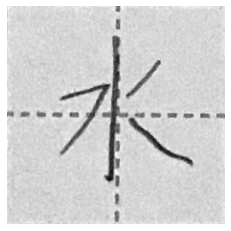

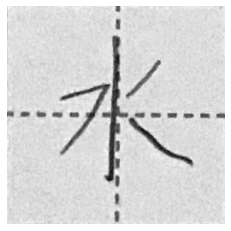

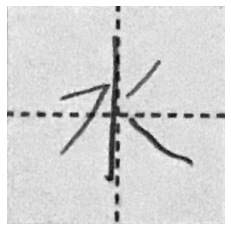

In [412]:
gray = sqs.squares[1].arr()[:,:,0]
my_cv.display_gray(gray)
gray = sqs.squares[1].arr()[:,:,1]
my_cv.display_gray(gray)
gray = sqs.squares[1].arr()[:,:,2]
my_cv.display_gray(gray)

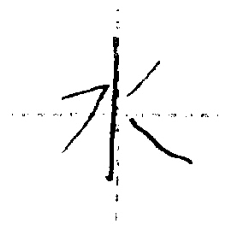

In [413]:
ret, img_thresh = cv2.threshold(sqs.squares[1].arr()[:,:,0], 60, 255, cv2.THRESH_BINARY)
my_cv.display_gray(img_thresh)

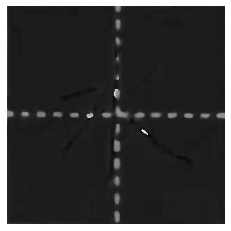

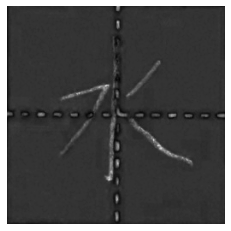

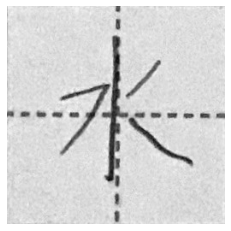

In [416]:
hsv = cv2.cvtColor(sqs.squares[1].arr(), cv2.COLOR_BGR2HSV)
my_cv.display_gray(hsv[:,:,0])
my_cv.display_gray(hsv[:,:,1])
my_cv.display_gray(hsv[:,:,2])